In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import cv2 as cv
import zipfile
from PIL import Image
import torchvision
import shutil
from tqdm import tqdm

In [3]:
with zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

After zip extraction:
['__notebook__.ipynb', 'train']


In [4]:
with zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

After zip extraction:
['__notebook__.ipynb', 'train', 'test1']


In [5]:
test_dir = "/kaggle/working/test1"
train_dir = "/kaggle/working/train"
cat_files = [name for name in os.listdir("/kaggle/working/train") if "cat" in name]
dog_files = [name for name in os.listdir("/kaggle/working/train") if "dog" in name]

In [6]:
len(cat_files), len(dog_files)

(12500, 12500)

In [7]:
class DogCat(Dataset):
    def __init__(self, file_names, file_dir, transform = None, mode='train'):
        self.file_names = file_names
        self.file_dir = file_dir
        self.transform = transform
        self.mode = mode
        if self.mode == "train":
            if 'cat' in self.file_names[0]:
                self.label = 0
            else: 
                self.label = 1
                
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.file_dir, self.file_names[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == "train":
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_names[idx].split('.')[1]
        

In [8]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


cat_data = DogCat(cat_files, train_dir, data_transform)
dog_data = DogCat(dog_files, train_dir, data_transform)

train_data = ConcatDataset([cat_data, dog_data])

In [9]:
len(train_data)

25000

In [10]:
dataloader = DataLoader(train_data, batch_size = 32, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


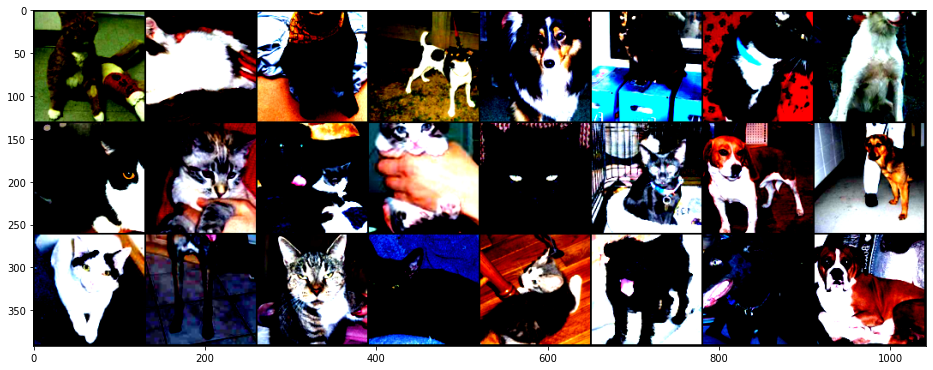

In [11]:
import matplotlib.pyplot as plt

samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [12]:
from torchvision import models

device = 'cuda'

model = torchvision.models.densenet121(pretrained=True)

for param in model.parameters(): 
    param.requires_grad = False 
    
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.classifier.in_features, 500),
    torch.nn.Linear(500, 2)
)
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [13]:
test_transforms = [
    transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
    transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize((128, 128)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
]

In [14]:
epochs = 3
i = 1
check = len(dataloader) // 4
model.train()
total_loss = 0
loss_list = []
acc_list = []
acc = []
for epoch in range(epochs):
    for imgs, labels in tqdm(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        predict = model(imgs)
        loss_predict = loss(predict, labels)
        loss_predict.backward()
        optimizer.step()
        total_loss += loss_predict.item()
        scheduler.step()
        
        if i % check == 0:
            pred = torch.argmax(predict, dim=1)
            correct = pred.eq(labels)
            acc.append(torch.mean(correct.float()).cpu().numpy())
            loss_list.append(total_loss)
#             
            
        i += 1
    print(f'Epoch: {epoch}, loss: {np.mean(total_loss)}, acc: {np.mean(acc)}')
    acc_list.append(np.mean(acc))
    total_loss = 0

100%|██████████| 782/782 [02:39<00:00,  4.91it/s]


Epoch: 0, loss: 213.1308318078518, acc: 0.921875


100%|██████████| 782/782 [02:33<00:00,  5.09it/s]


Epoch: 1, loss: 209.54106558859348, acc: 0.90234375


100%|██████████| 782/782 [02:36<00:00,  4.99it/s]

Epoch: 2, loss: 208.45818082988262, acc: 0.9010416865348816


In [15]:
test_imgs = [f for f in os.listdir(test_dir) if '.jpg' in f]

In [16]:
del(cat_data, dog_data, train_data, dataloader)

In [17]:
df = pd.DataFrame
# cat_files, train_dir, data_transform
for transform in test_transforms:
    test_data = DogCat(test_imgs, test_dir, mode='test', transform=transform)
    testloader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4)

    model.eval()

    file_names = []
    res = []

    for x, fn in tqdm(testloader):
        with torch.no_grad():
            x = x.to(device)
            output = model(x)
            file_names += fn
            res.append(torch.nn.functional.softmax(output, dim=1)[:,1].data.cpu().numpy())
            
    img_id = [i.split('.')[0] for i in file_names]
    res = np.concatenate(res)
    final = pd.DataFrame({'id': img_id, 'label': res})
    final.set_index('id', inplace=True)
    
    try : df = df.merge(final, how='inner', on='id') 
        
    except BaseException: 
        df = final 
df.head(8)

100%|██████████| 3125/3125 [02:10<00:00, 23.94it/s]


,label_x,label_y
id,,
jpg,0.151879,0.017273
jpg,0.151879,0.476910
jpg,0.151879,0.240013
jpg,0.151879,0.052125
jpg,0.151879,0.136537
jpg,0.151879,0.057351
jpg,0.151879,0.954169
jpg,0.151879,0.364304


In [18]:
del(test_data, testloader)

In [19]:
new_df = df
new_df['mean'] = new_df.mean(axis=1)
new_df.drop(new_df.columns[:-1], axis='columns', inplace=True)
new_df['label'] = new_df['mean'].map(lambda pred: 'cat' if pred < 0.50 else 'dog')
new_df.drop(new_df.columns[:-1], axis='columns', inplace=True)
new_df.head(13)
new_df.to_csv('submission.csv')